## Module imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import median_abs_deviation
from astropy.stats import sigma_clip
from astropy.table import Table
from astropy.time import Time
from tqdm import tqdm
%matplotlib inline

In [2]:
cd ..

/Users/azib/Documents/PhD/Exocomets/automated_exocomet_hunt


In [3]:
import data 
import loaders

### SPOcc files

In [4]:
def import_XRPlightcurve(file_path):
    """
    Importing the compressed TESS lightcurves from the XRP group.
    file_path: path to file
    :type file_path: pkl
    :returns: 
        - lc - lightcurve data as a DataFrame. 
        - store - Storage of other information (TIC, RA, Dec, TESS magnitude, Camera, Chip)
    """
    data = pd.read_pickle(file_path)

    ## extracting the lightcurve data and converting to Series from lists
    for i in range(len(data)):
        if isinstance(data[i],np.ndarray):
            data[i] = pd.Series(data[i])
    for_df = data[6:] # data[0:6] is not relevant in this case.
    columns = ['time','raw flux','corrected flux','PCA flux','flux error','quality']
    df = pd.DataFrame(data=for_df).T
    df.columns = columns
    return df, data[0:6]

def normalise_lc(flux):
    return flux/flux.mean()

In [5]:
filename = 'tess/tesslcs_sector_14_104_2_min_cadence_targets_tesslc_122519163.pkl'
lc, store = import_XRPlightcurve(filename)
lc['normalised PCA'] = normalise_lc(lc['PCA flux'])

### First lightcurve

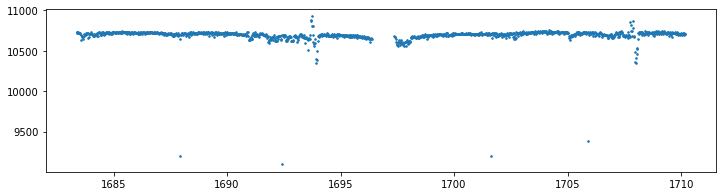

In [6]:
plt.figure(figsize=(12,3))
#lc['normalised PCA'][lc.quality==0].plot()
plt.scatter(lc['time'],lc['raw flux'],s=2.5)
#plt.ylim(340000,355000)
plt.show()

#### Reading in bad times data and target data.

In [7]:
bad_times = data.load_bad_times()
bad_times = bad_times - 2457000
mad_df = data.load_mad()

In [8]:
sec = int(filename.split('_')[2])
cam = store[4]
mad_arr = mad_df.loc[:len(lc)-1, f"{sec}-{cam}"]

In [9]:
np.count_nonzero(np.isnan(mad_arr))

255

### Testing MAD Thresholds

In [10]:
np.nanmedian(mad_arr)

0.0015885235999999999

In [11]:
np.std(mad_arr[900:950])

0.00013317909363043262

**Taking the MAD of `mad_arr`**

In [12]:
3*(1.48*median_abs_deviation(mad_arr,nan_policy='omit'))

0.0019870889219999995

**Sigma Clipping**

In [13]:
sig_clip = sigma_clip(mad_arr,sigma=3,masked=False)
med_sig_clip = np.nanmedian(sig_clip)
med_sig_clip

0.00148086695

**RMS of Sigma Clipping**

In [14]:
rms_sig_clip = np.sqrt(np.mean((sig_clip-med_sig_clip)**2))
rms_sig_clip 

0.0005645222361301955

In [15]:
np.std(sig_clip)

0.0005338896740044282

### MAD plots

For each Sector-Camera combination, any cadences above a threshold are flagged. The threshold is defined as 10 times the standard deviation of MAD values for a quiet portion of the plot, visually identified as cadences 900 to 950, plus the median MAD value of the quiet section. The 10-sigma threshold was determined visually to preserve most data while culling the most problematic sections.

$$\text{threshold} = \texttt{med}(\text{MAD}_{quiet})+ 10*\sigma_{quiet}$$



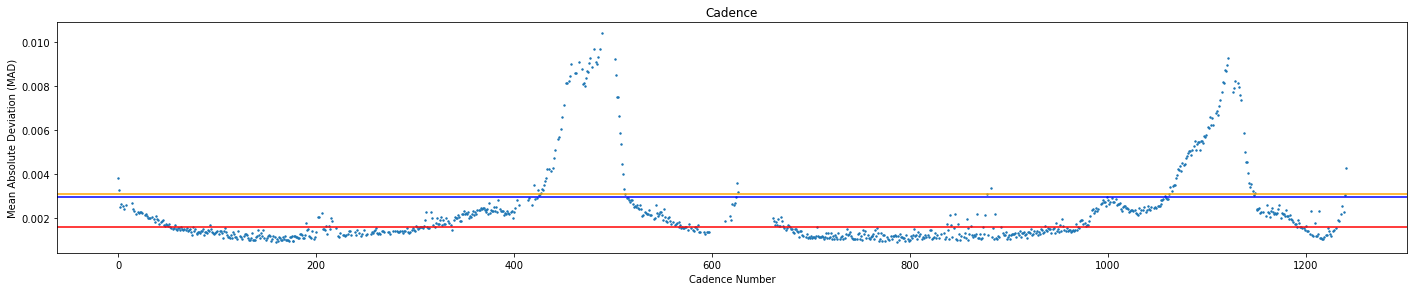

In [16]:
fig,ax = plt.subplots(1,figsize=(10,4))
# ax1.scatter(lc.time, mad_arr, s=2)
# 
# #ax1.axhline(med_sig_clip, c='r',linestyle='--')
# ax1.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[700:800]),c='blue') # 10 sigma threshold
# 
# #ax1.axhline(np.nanmedian(mad_arr)+3*(1.48*median_abs_deviation(mad_arr,nan_policy='omit')),c='blue')
# #ax1.axhline(np.nanmedian(mad_arr)+(med_sig_clip),c='blue')
# #ax1.axhline(np.nanmedian(mad_arr)+(rms_sig_clip),c='orange')

ax.scatter(range(0,len(lc.time)), mad_arr, s=2)
ax.axhline(np.nanmedian(mad_arr), c='r')
ax.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[700:800]),c='blue') # 10 sigma threshold
ax.axhline(med_sig_clip + 3*(np.std(sig_clip)), c='orange')




ax.set_xlabel('Cadence Number')
ax.set_ylabel('Mean Absolute Deviation (MAD)')
ax.set_title('Cadence')
plt.subplots_adjust(bottom=0.1, right=2.0, top=0.9)
plt.show()

---

Note: higher `mad_arr`, higher deviation/error. Hence cutoff with `mad_cut`:

In [17]:
mad_cut = mad_arr.values<(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950])) # removes any values above threshold
mad_cut2 = mad_arr.values<(med_sig_clip + 3*(np.std(sig_clip)))

Creating the `bad_times` mask

In [18]:
mask = np.ones_like(lc.time, dtype=bool)
for i in bad_times:
    newchunk = (lc.time<i[0])|(lc.time>i[1])
    mask = mask & newchunk

### Comparison of plots (`quality = 0`)

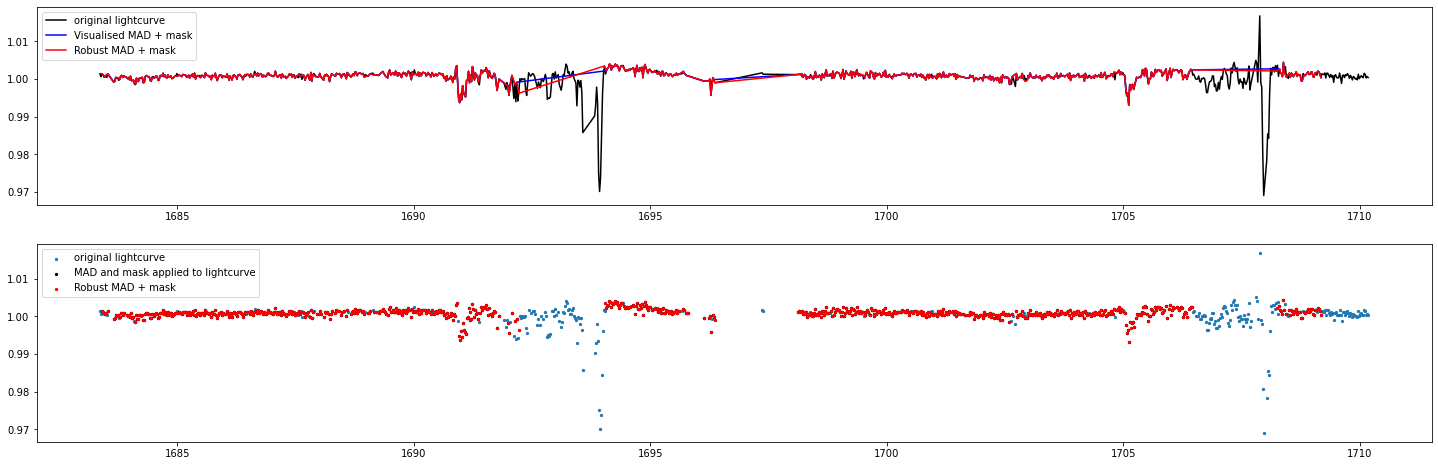

In [19]:
fig,ax = plt.subplots(2,figsize=(25,8))

ax[0].plot(lc['time'][lc.quality==0],lc['normalised PCA'][lc.quality==0],label='original lightcurve',color='black')
ax[0].plot(lc['time'][(lc.quality==0) & mask & mad_cut],lc['normalised PCA'][(lc.quality==0) & mask & mad_cut],c='blue',label='Visualised MAD + mask')
ax[0].plot(lc['time'][(lc.quality==0) & mask & mad_cut2],lc['normalised PCA'][(lc.quality==0) & mask & mad_cut2],c='red',label='Robust MAD + mask')

ax[1].scatter(lc['time'][lc.quality==0],lc['normalised PCA'][lc.quality==0],label='original lightcurve',s=5)
ax[1].scatter(lc['time'][(lc.quality==0) & mask & mad_cut],lc['normalised PCA'][(lc.quality==0) & mask & mad_cut],c='black',label='MAD and mask applied to lightcurve',s=5)
ax[1].scatter(lc['time'][(lc.quality==0) & mask & mad_cut2],lc['normalised PCA'][(lc.quality==0) & mask & mad_cut2],c='red',label='Robust MAD + mask',s=5)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
#plt.ylim(0.9975,1.005)
plt.show()

### Notes:

- The task is to mask the bad quality data in the lightcurves even when the quality flags are set to zero `lc.quality=0`.
- To do so, we use Ethan Kruse's masks, which provide the "bad times" in each sector and we adjust the offset accordingly. These bad times represent an excess of false transits.
- We then use the Median Absolute Deviation (MAD), given by: 
    
    $$\text{MAD}(t)=\texttt{median}(\{|F_{lc}(t)-\bar{F_t}|\text{ }|\text{ }lc\in \text{SCD}\})$$
    
- The MAD is used to identify offending cadences, and it is computed for each cadence by Sector/Camera/Detector (SCD). The MAD at a cadence centered at a time, t, for a given set of light curves in a (SCD) is the median value of the set of absolute value deviations from the median flux at that time.


## Preamble - Testing how effective our Robust MAD is against the Visualised MAD

In [20]:
sectors = np.arange(1,27,1)
cam = [1,2,3,4]
clip = np.arange(0,10,1)

#### Comparison plot of SC combination with the median line, Daniel's visualised MAD, and our Sigma Clipped MAD

- A limitation discussed was that the visualised MAD, although very effective, focuses on a very small region, eg `[900:950]`, to pick up the standard deviation term, $\sigma_{quiet}$, rather than the whole ensemble. This becomes limited when we want to explore new sectors automatically and perhaps integrate with other data. Below is a plot of the median, visualised MAD and a Sigma Clipped MAD to observe the performance of the Sigma Clipped MAD (clipped at 3 Sigma for this example).

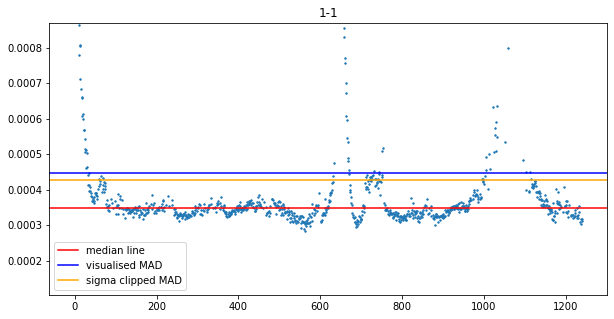

<Figure size 1008x360 with 0 Axes>

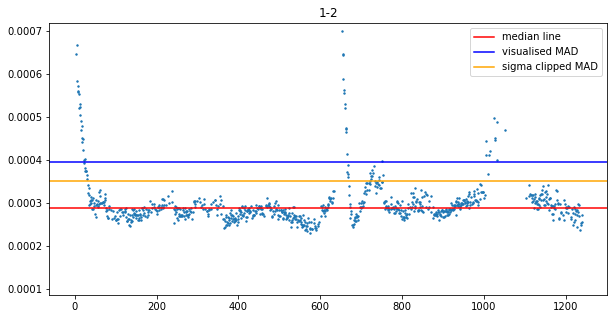

<Figure size 1008x360 with 0 Axes>

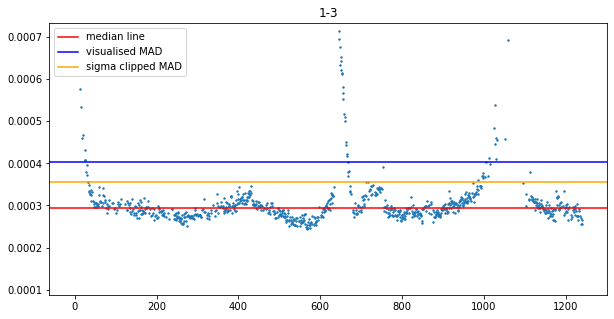

<Figure size 1008x360 with 0 Axes>

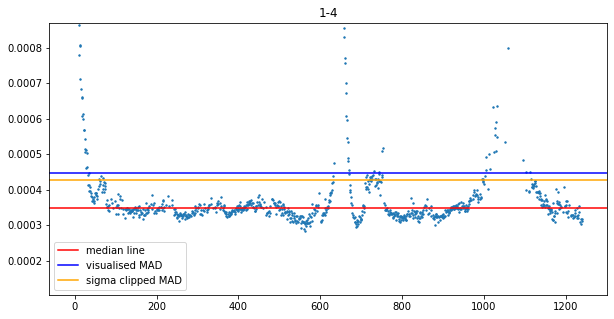

<Figure size 1008x360 with 0 Axes>

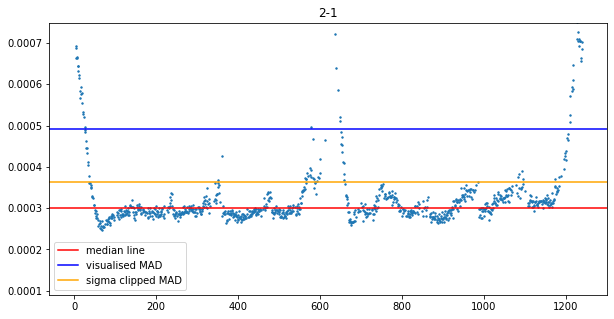

<Figure size 1008x360 with 0 Axes>

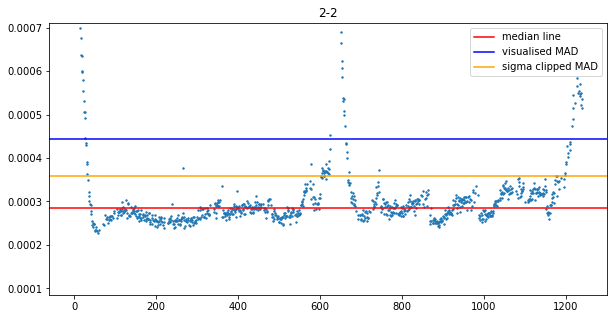

<Figure size 1008x360 with 0 Axes>

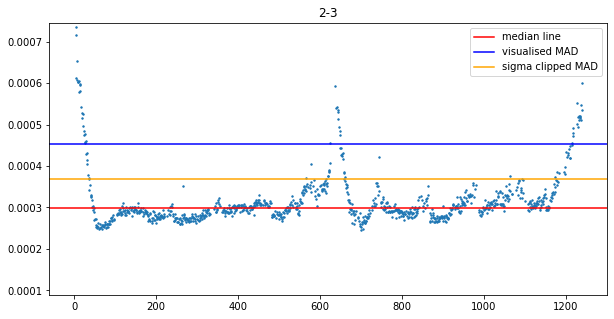

<Figure size 1008x360 with 0 Axes>

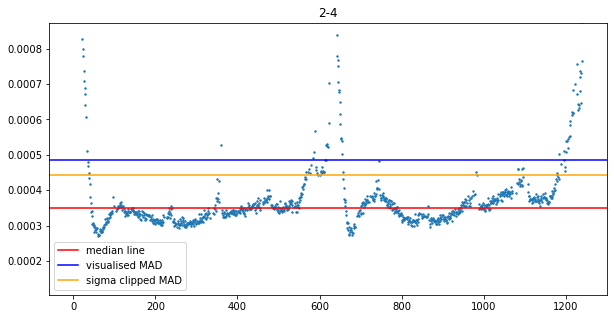

<Figure size 1008x360 with 0 Axes>

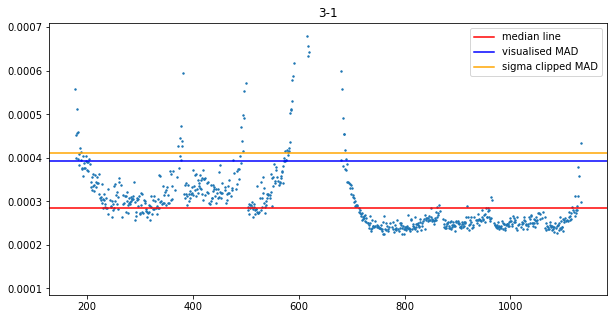

<Figure size 1008x360 with 0 Axes>

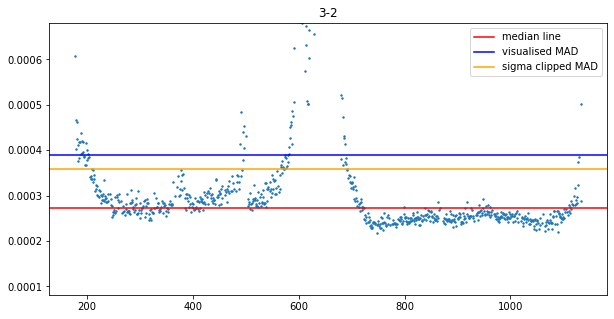

<Figure size 1008x360 with 0 Axes>

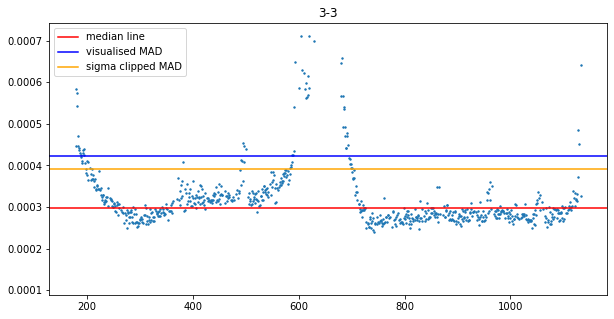

<Figure size 1008x360 with 0 Axes>

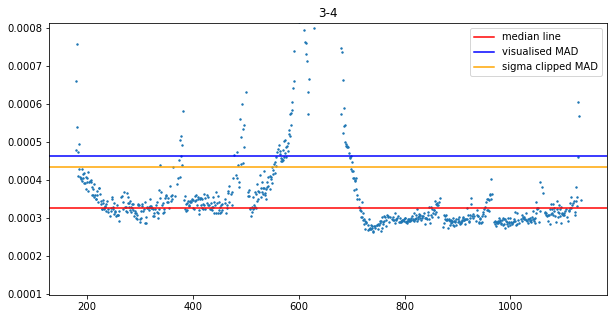

<Figure size 1008x360 with 0 Axes>

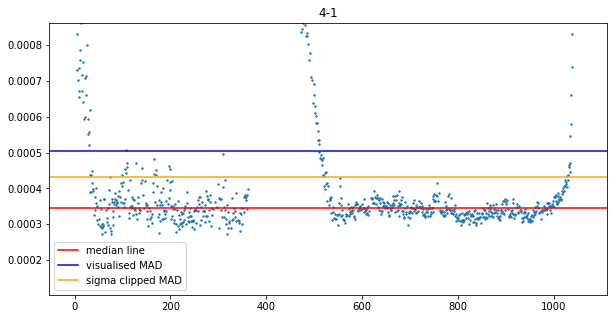

<Figure size 1008x360 with 0 Axes>

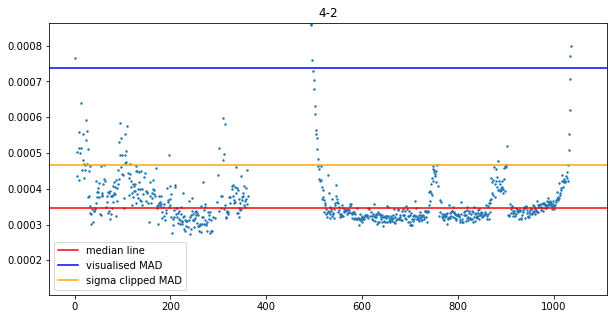

<Figure size 1008x360 with 0 Axes>

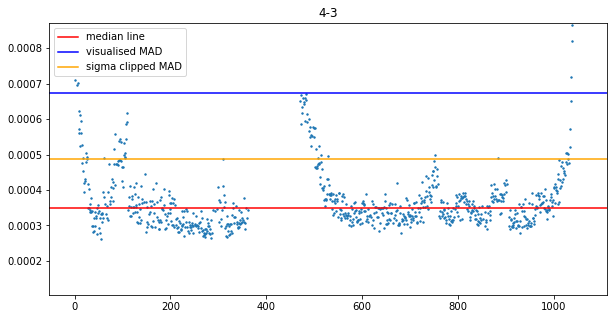

<Figure size 1008x360 with 0 Axes>

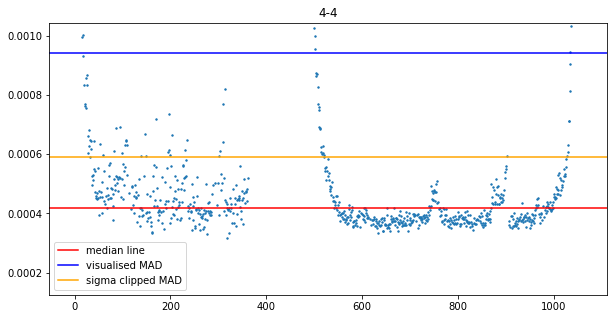

<Figure size 1008x360 with 0 Axes>

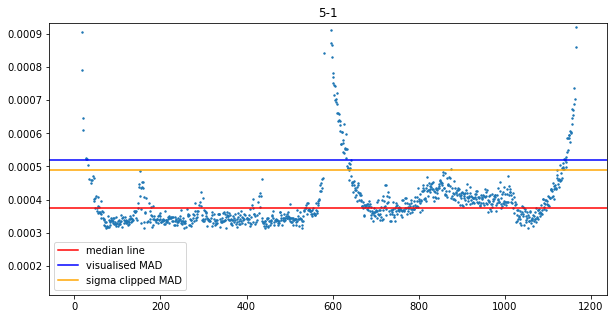

<Figure size 1008x360 with 0 Axes>

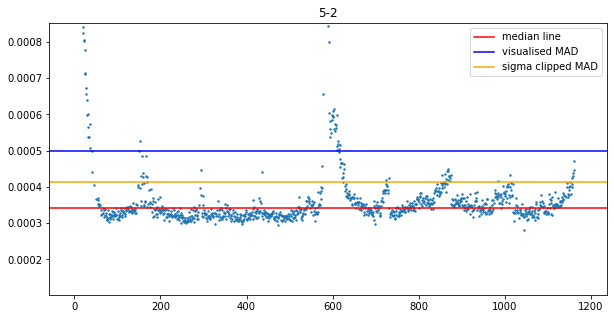

<Figure size 1008x360 with 0 Axes>

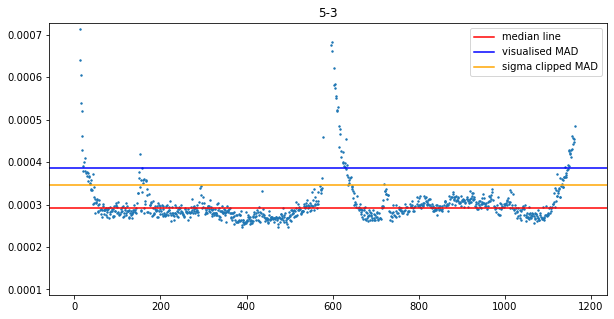

<Figure size 1008x360 with 0 Axes>

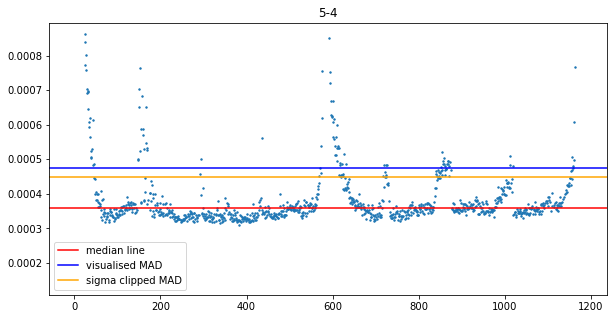

<Figure size 1008x360 with 0 Axes>

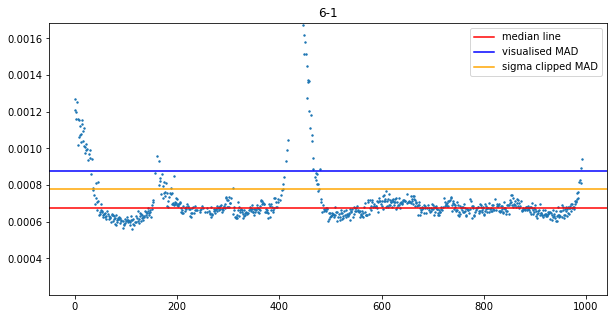

<Figure size 1008x360 with 0 Axes>

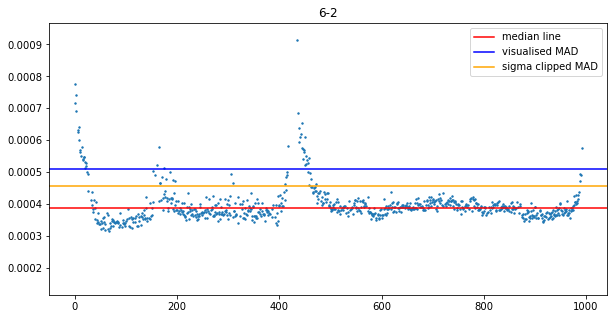

<Figure size 1008x360 with 0 Axes>

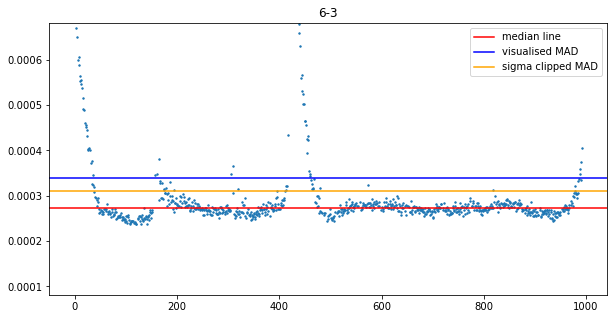

<Figure size 1008x360 with 0 Axes>

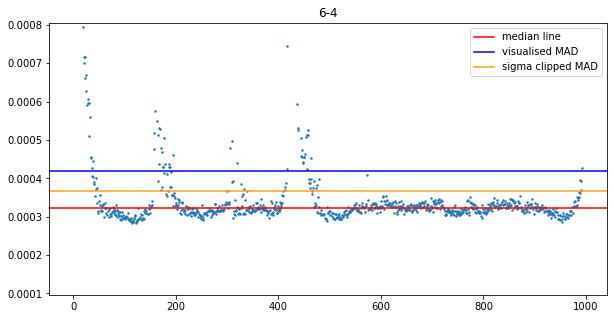

<Figure size 1008x360 with 0 Axes>

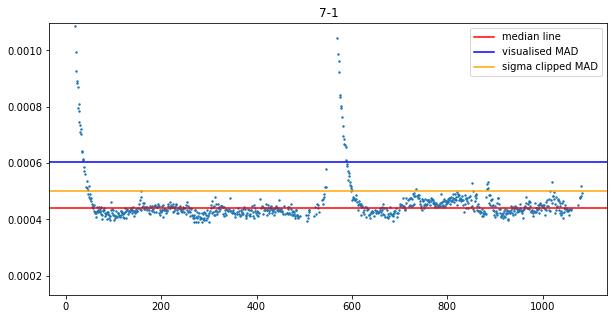

<Figure size 1008x360 with 0 Axes>

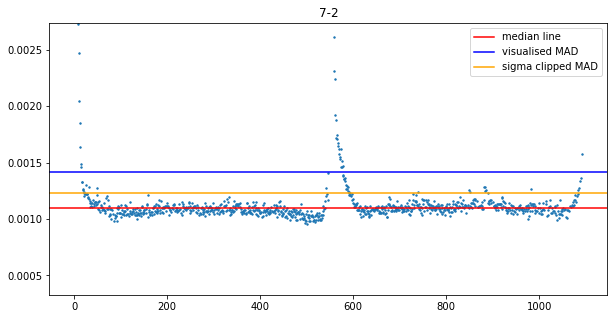

<Figure size 1008x360 with 0 Axes>

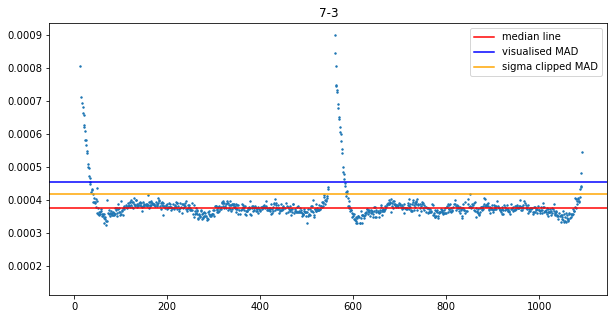

<Figure size 1008x360 with 0 Axes>

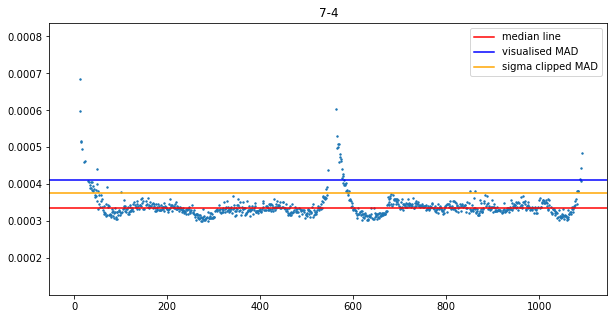

<Figure size 1008x360 with 0 Axes>

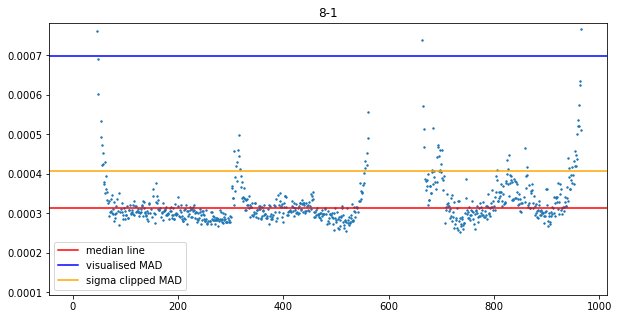

<Figure size 1008x360 with 0 Axes>

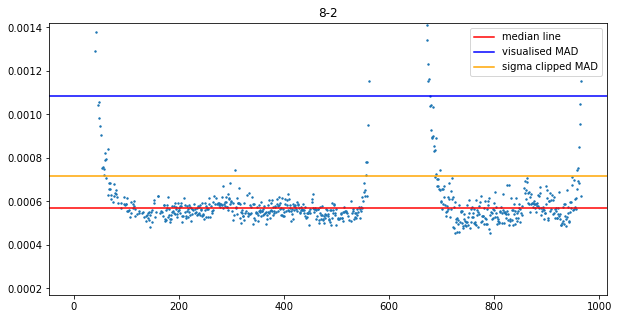

<Figure size 1008x360 with 0 Axes>

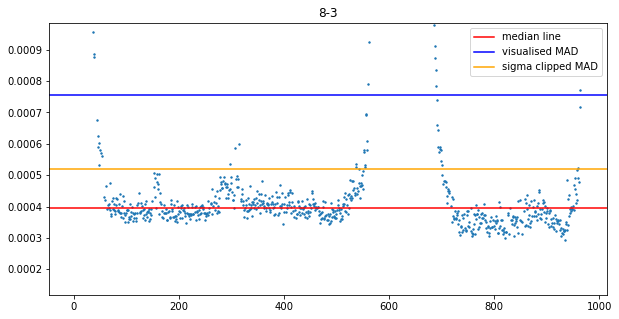

<Figure size 1008x360 with 0 Axes>

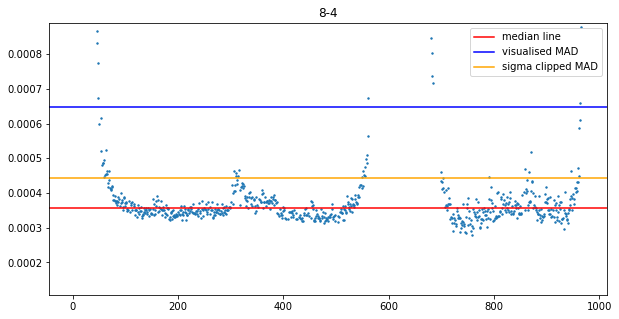

<Figure size 1008x360 with 0 Axes>

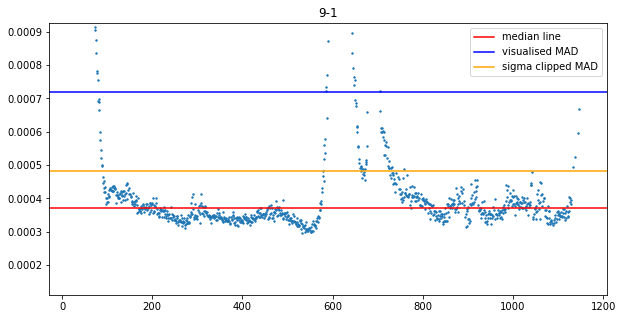

<Figure size 1008x360 with 0 Axes>

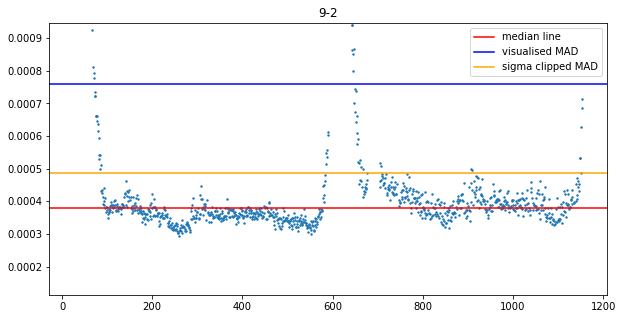

<Figure size 1008x360 with 0 Axes>

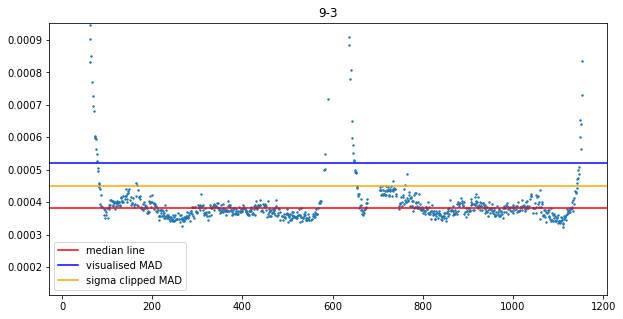

<Figure size 1008x360 with 0 Axes>

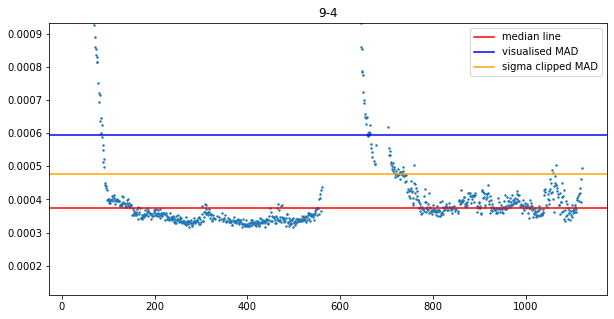

<Figure size 1008x360 with 0 Axes>

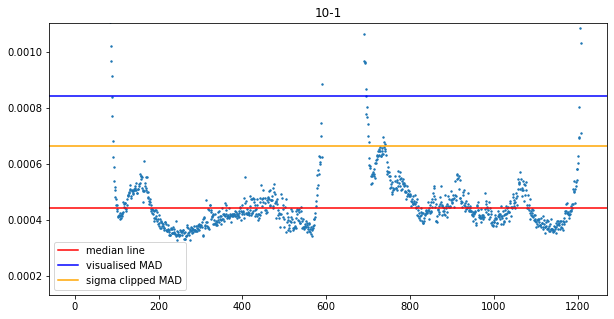

<Figure size 1008x360 with 0 Axes>

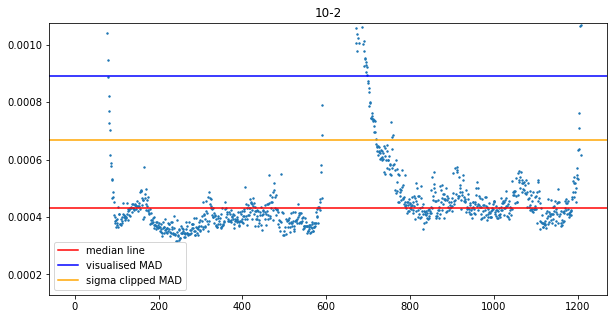

<Figure size 1008x360 with 0 Axes>

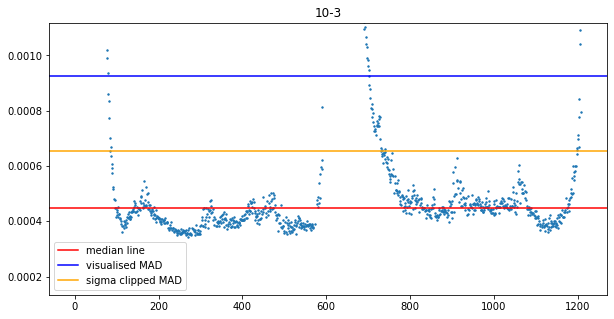

<Figure size 1008x360 with 0 Axes>

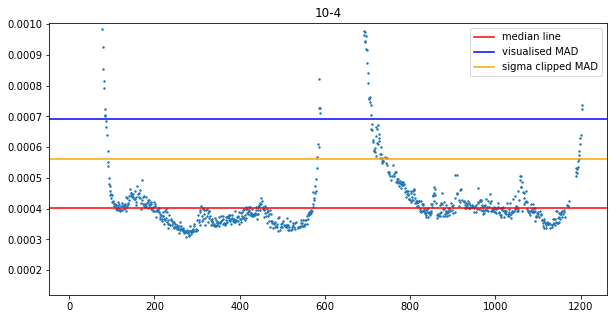

<Figure size 1008x360 with 0 Axes>

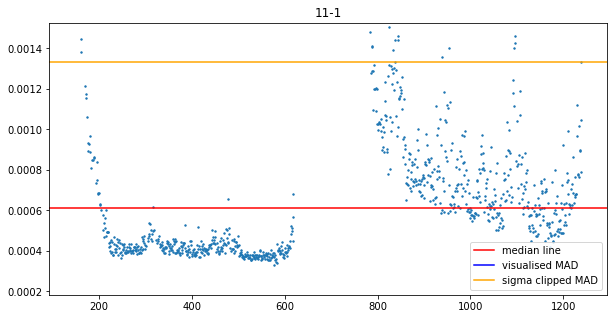

<Figure size 1008x360 with 0 Axes>

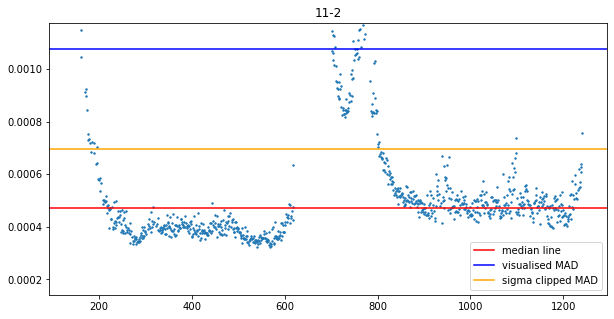

<Figure size 1008x360 with 0 Axes>

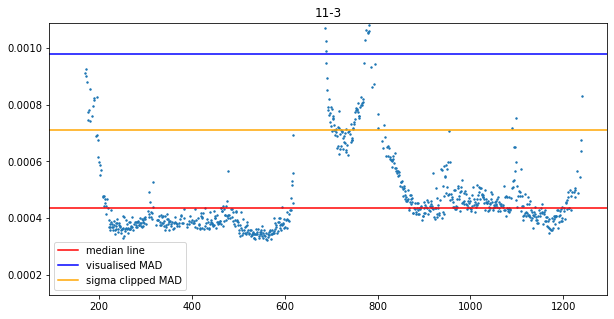

<Figure size 1008x360 with 0 Axes>

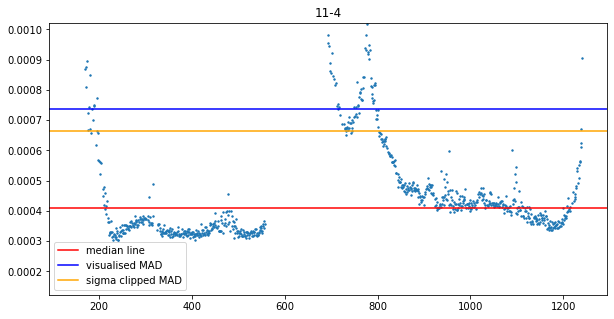

<Figure size 1008x360 with 0 Axes>

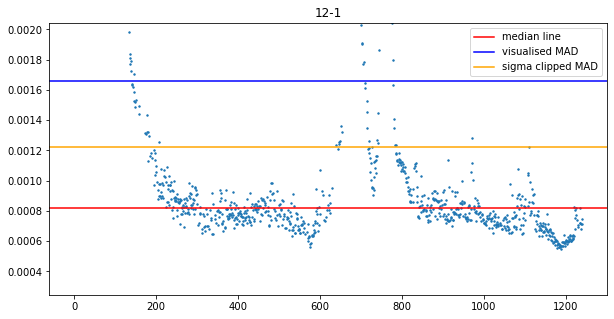

<Figure size 1008x360 with 0 Axes>

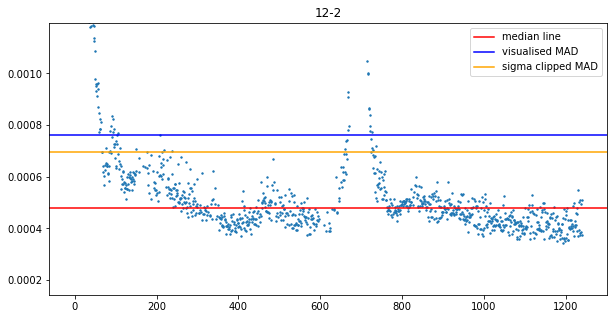

<Figure size 1008x360 with 0 Axes>

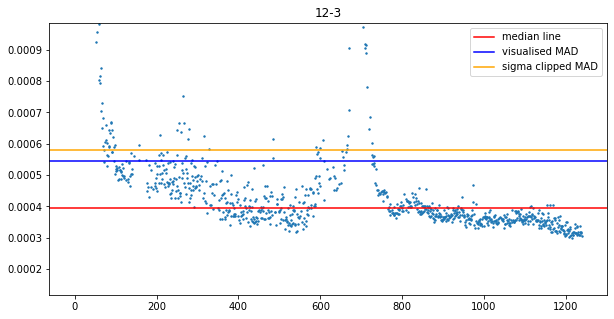

<Figure size 1008x360 with 0 Axes>

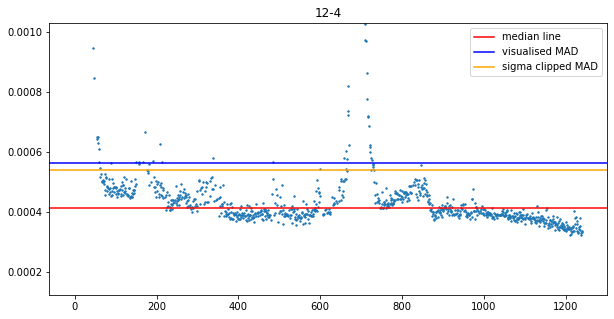

<Figure size 1008x360 with 0 Axes>

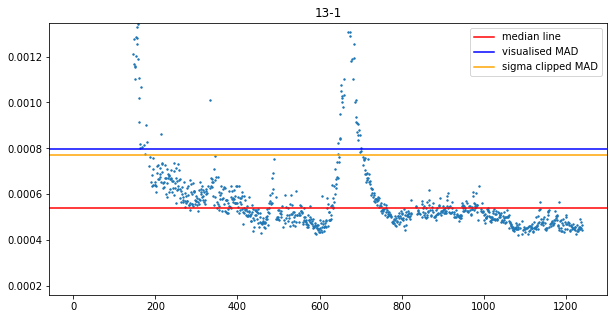

<Figure size 1008x360 with 0 Axes>

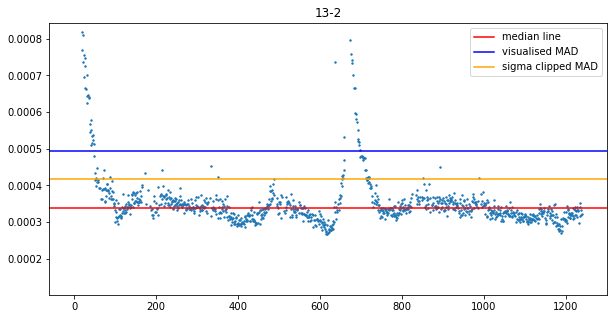

<Figure size 1008x360 with 0 Axes>

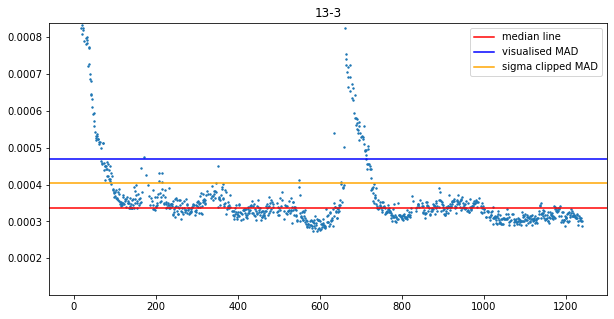

<Figure size 1008x360 with 0 Axes>

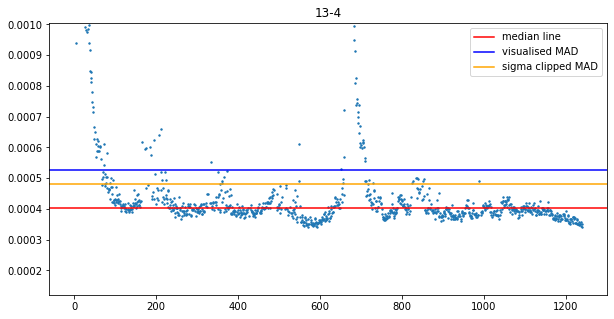

<Figure size 1008x360 with 0 Axes>

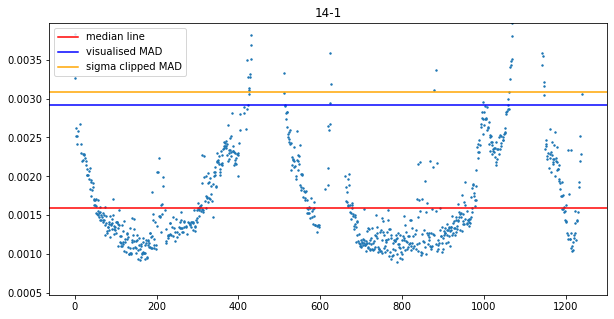

<Figure size 1008x360 with 0 Axes>

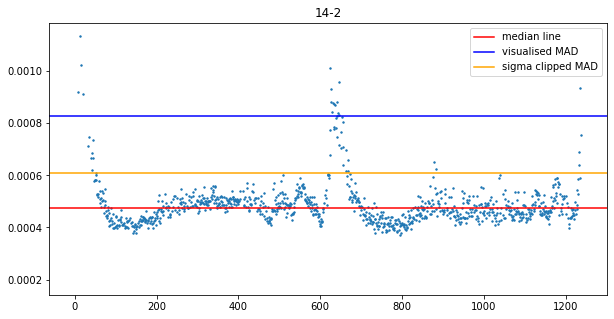

<Figure size 1008x360 with 0 Axes>

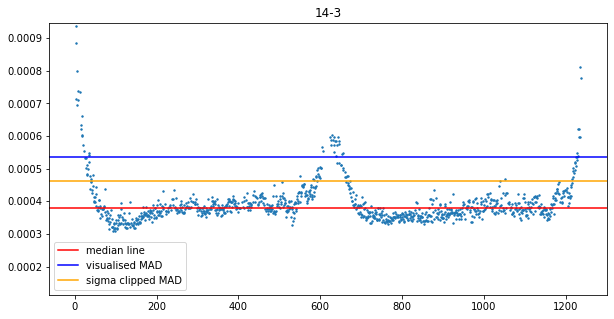

<Figure size 1008x360 with 0 Axes>

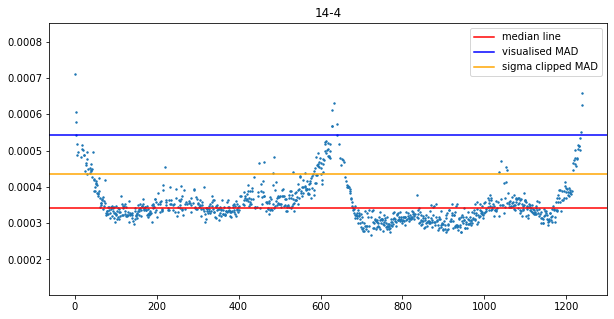

<Figure size 1008x360 with 0 Axes>

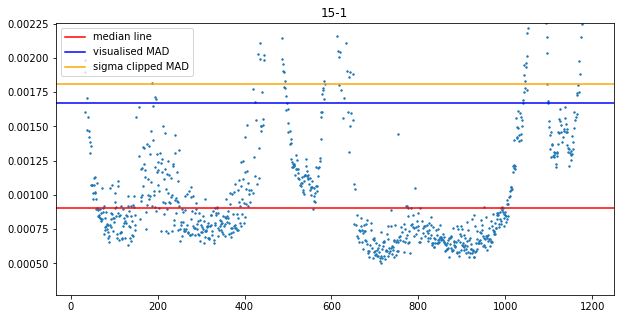

<Figure size 1008x360 with 0 Axes>

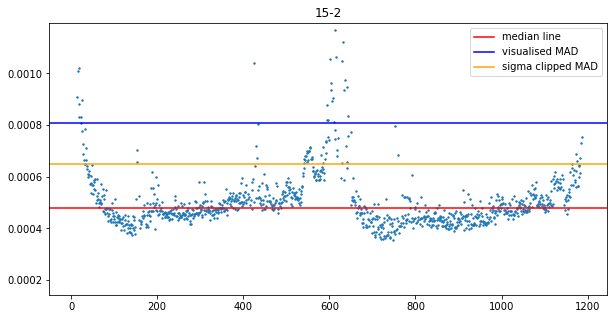

<Figure size 1008x360 with 0 Axes>

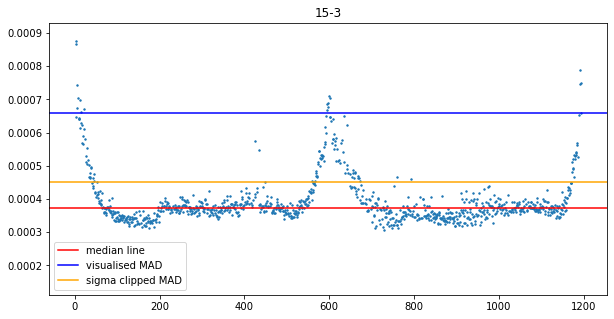

<Figure size 1008x360 with 0 Axes>

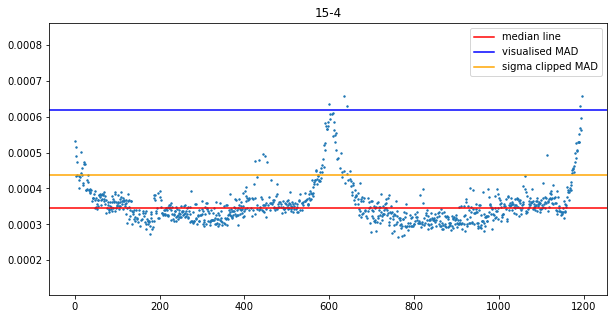

<Figure size 1008x360 with 0 Axes>

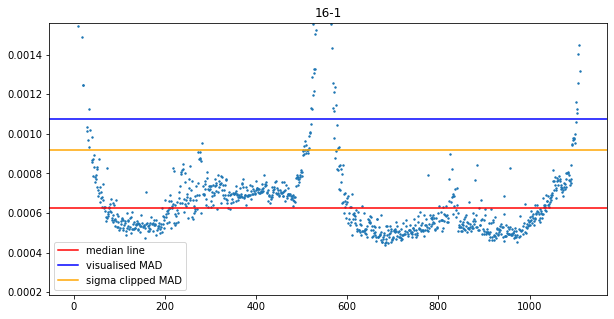

<Figure size 1008x360 with 0 Axes>

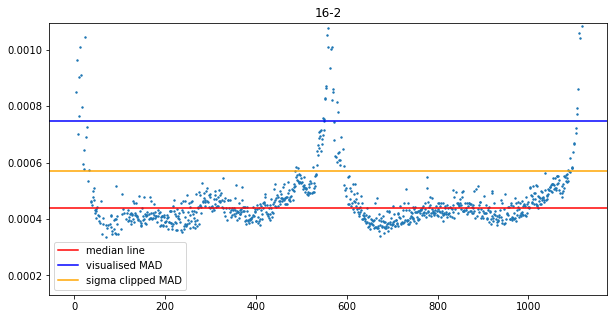

<Figure size 1008x360 with 0 Axes>

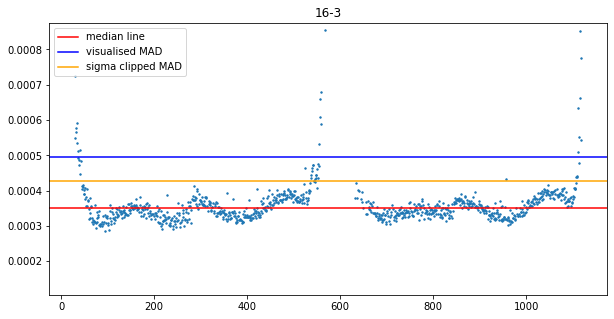

<Figure size 1008x360 with 0 Axes>

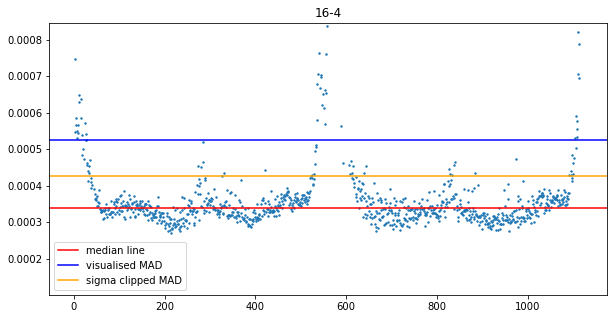

<Figure size 1008x360 with 0 Axes>

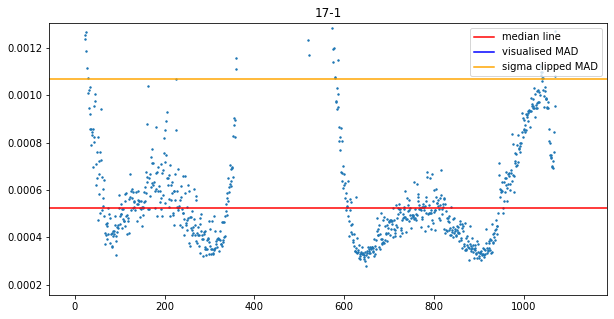

<Figure size 1008x360 with 0 Axes>

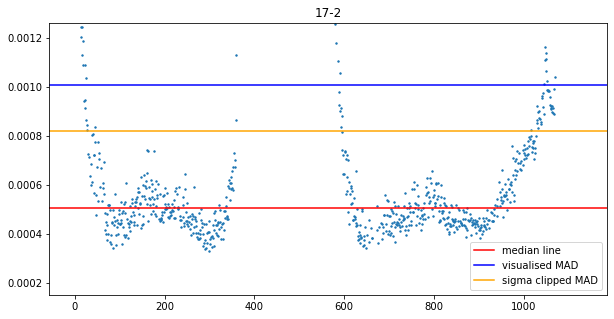

<Figure size 1008x360 with 0 Axes>

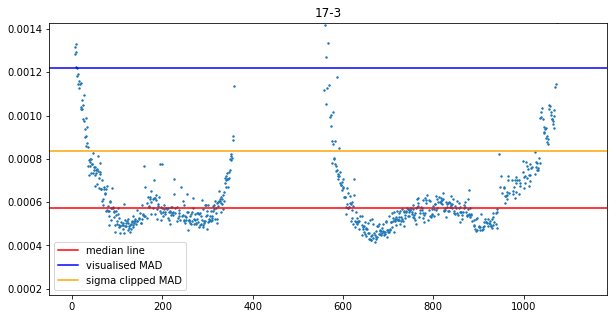

<Figure size 1008x360 with 0 Axes>

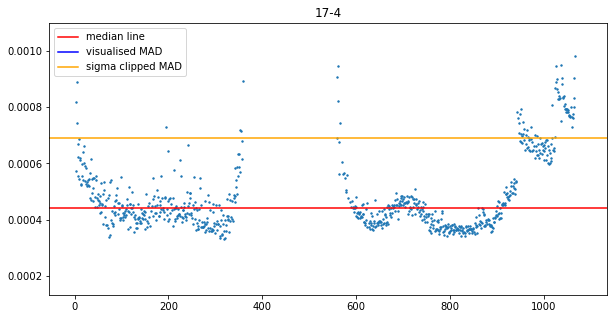

<Figure size 1008x360 with 0 Axes>

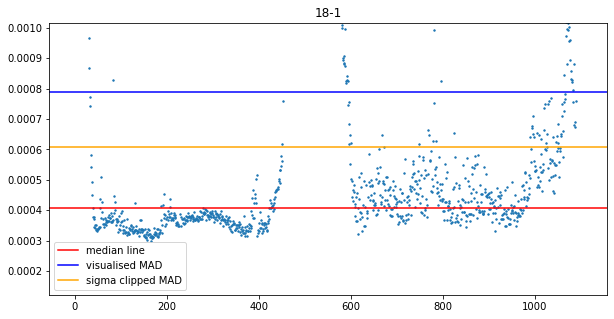

<Figure size 1008x360 with 0 Axes>

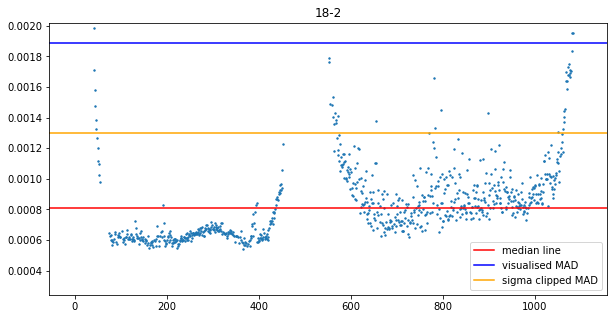

<Figure size 1008x360 with 0 Axes>

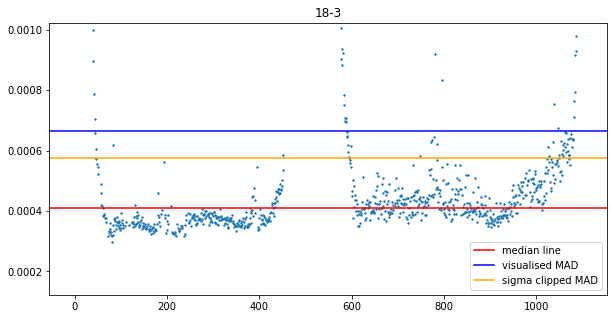

<Figure size 1008x360 with 0 Axes>

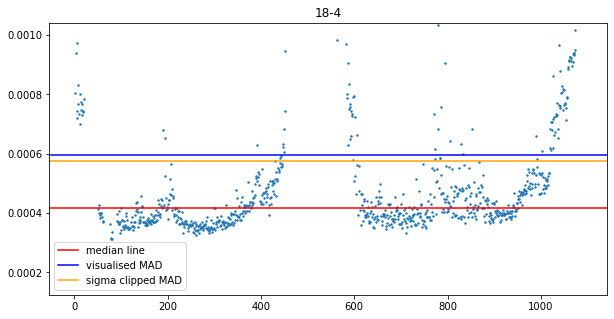

<Figure size 1008x360 with 0 Axes>

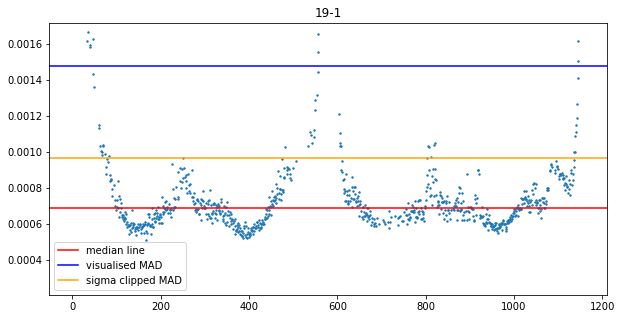

<Figure size 1008x360 with 0 Axes>

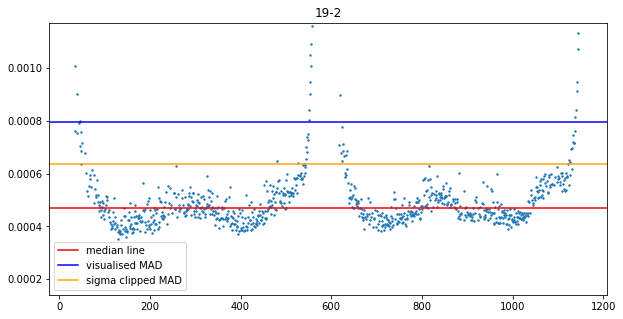

<Figure size 1008x360 with 0 Axes>

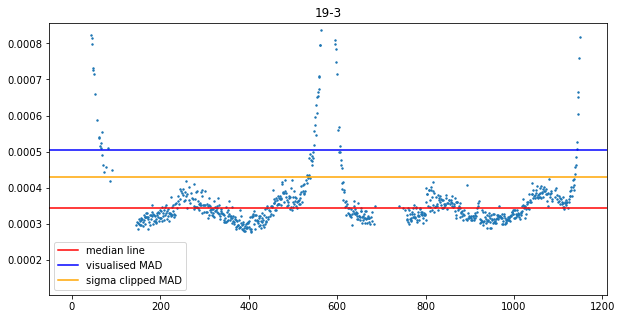

<Figure size 1008x360 with 0 Axes>

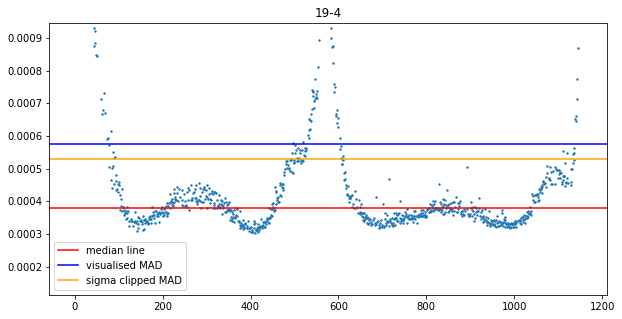

<Figure size 1008x360 with 0 Axes>

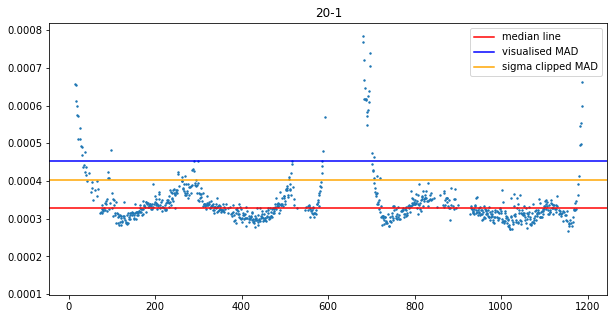

<Figure size 1008x360 with 0 Axes>

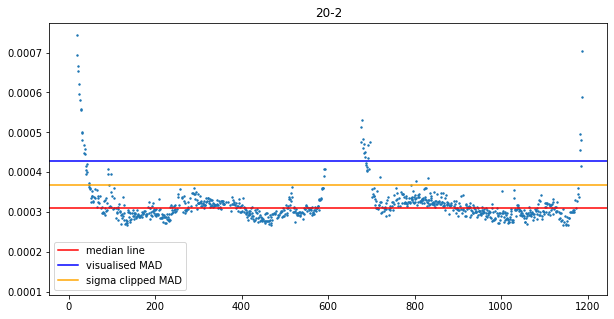

<Figure size 1008x360 with 0 Axes>

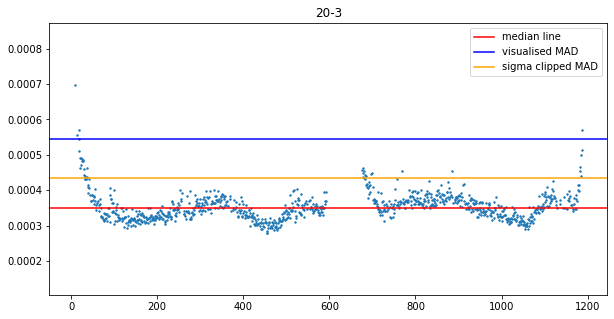

<Figure size 1008x360 with 0 Axes>

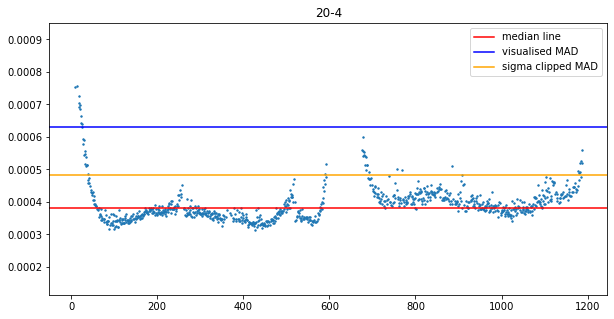

<Figure size 1008x360 with 0 Axes>

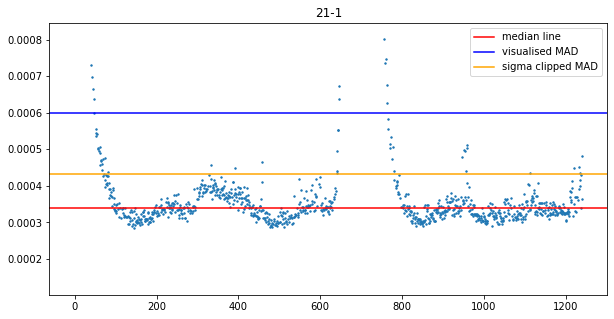

<Figure size 1008x360 with 0 Axes>

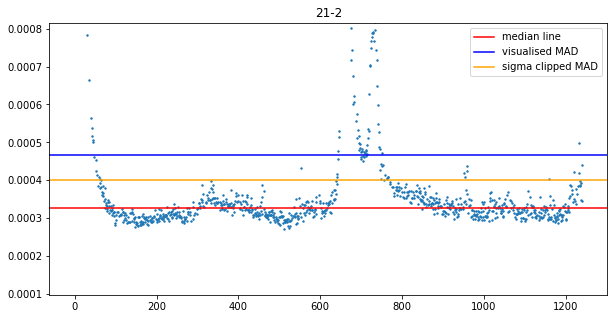

<Figure size 1008x360 with 0 Axes>

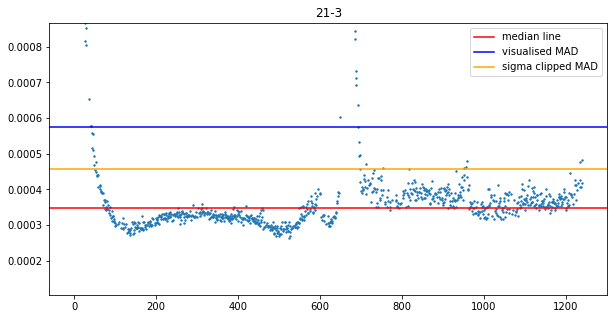

<Figure size 1008x360 with 0 Axes>

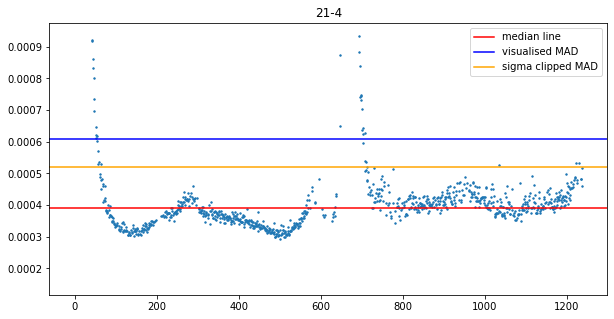

<Figure size 1008x360 with 0 Axes>

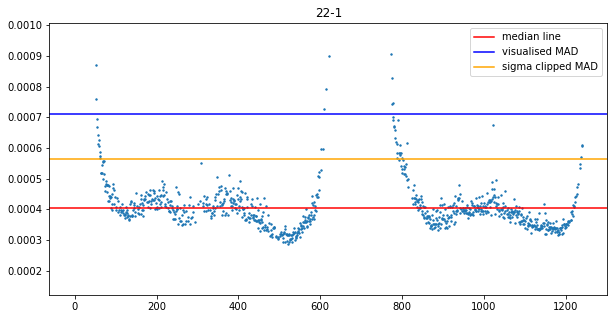

<Figure size 1008x360 with 0 Axes>

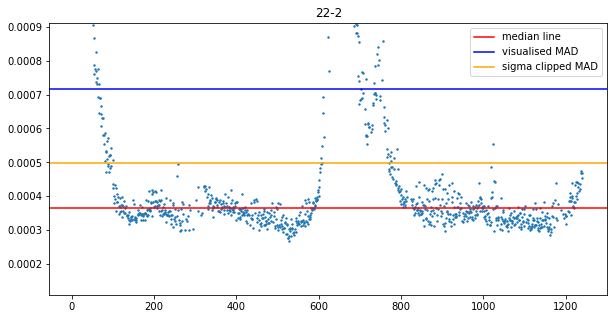

<Figure size 1008x360 with 0 Axes>

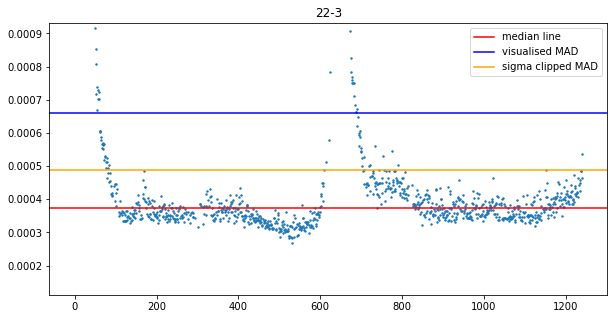

<Figure size 1008x360 with 0 Axes>

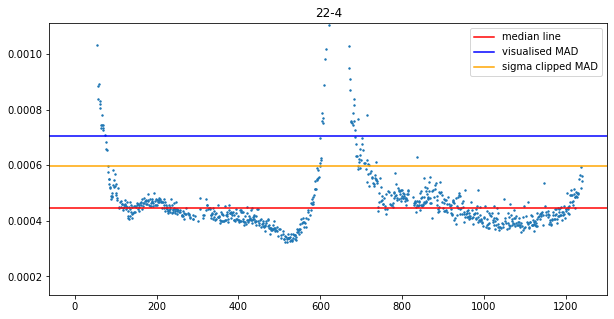

<Figure size 1008x360 with 0 Axes>

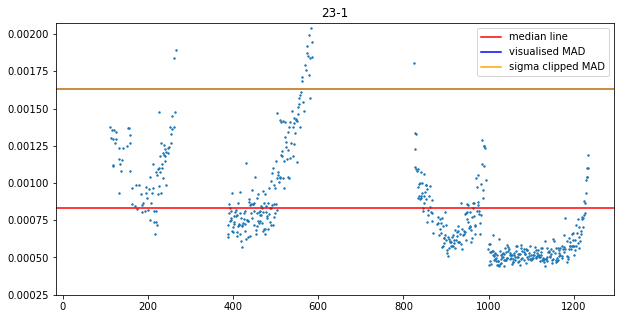

<Figure size 1008x360 with 0 Axes>

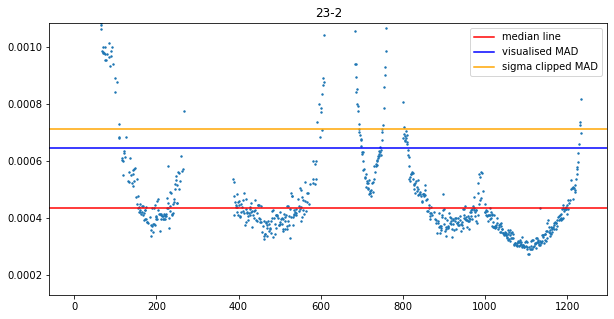

<Figure size 1008x360 with 0 Axes>

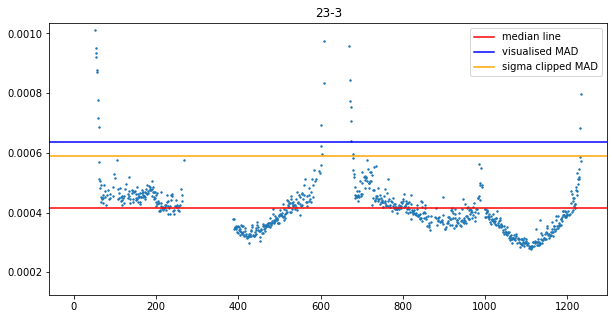

<Figure size 1008x360 with 0 Axes>

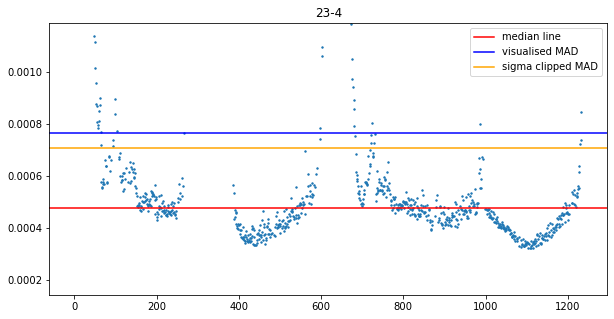

<Figure size 1008x360 with 0 Axes>

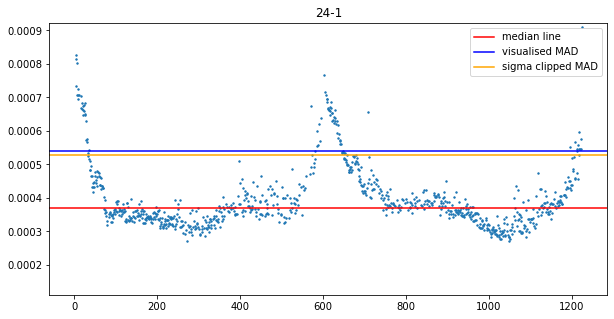

<Figure size 1008x360 with 0 Axes>

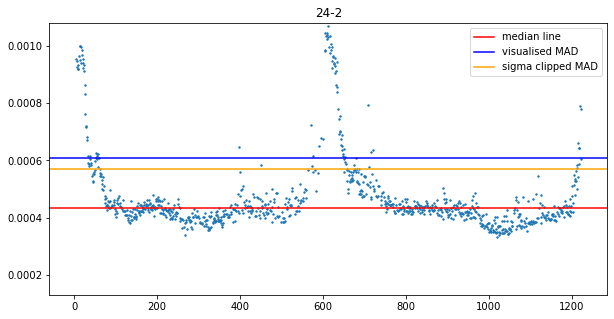

<Figure size 1008x360 with 0 Axes>

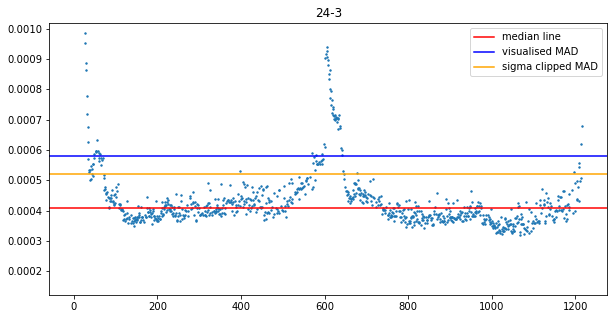

<Figure size 1008x360 with 0 Axes>

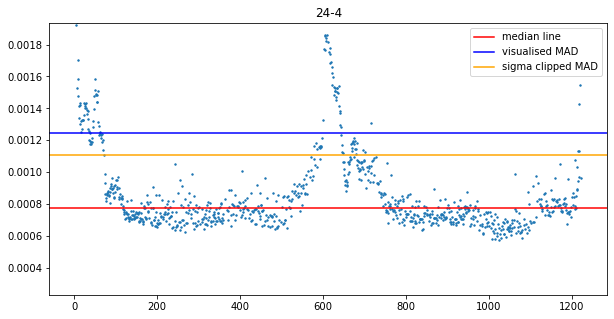

<Figure size 1008x360 with 0 Axes>

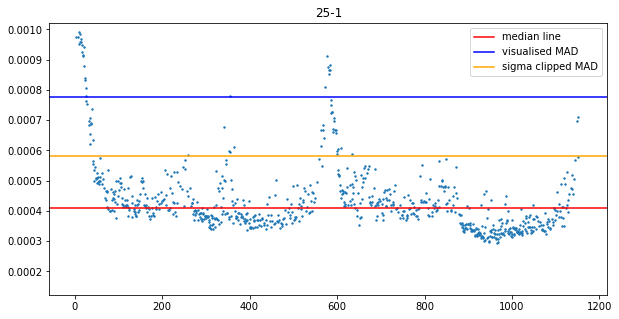

<Figure size 1008x360 with 0 Axes>

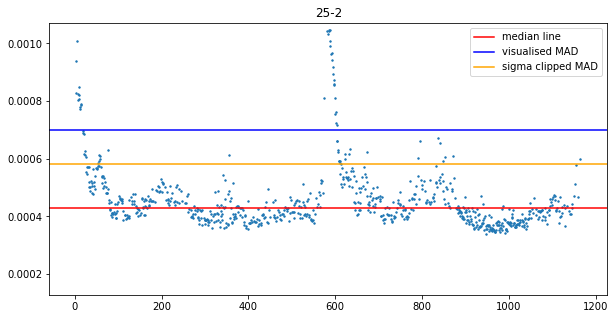

<Figure size 1008x360 with 0 Axes>

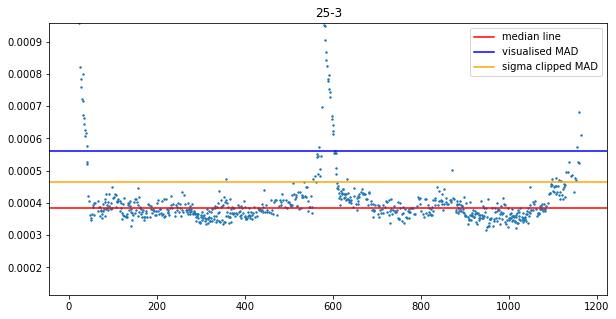

<Figure size 1008x360 with 0 Axes>

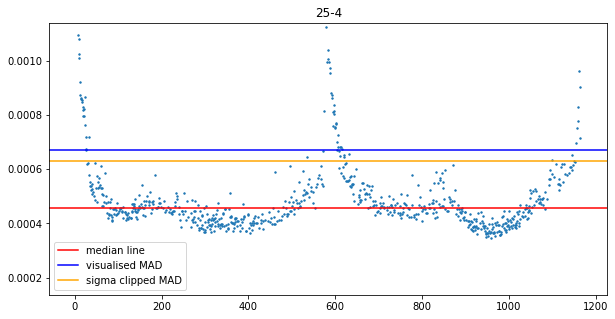

<Figure size 1008x360 with 0 Axes>

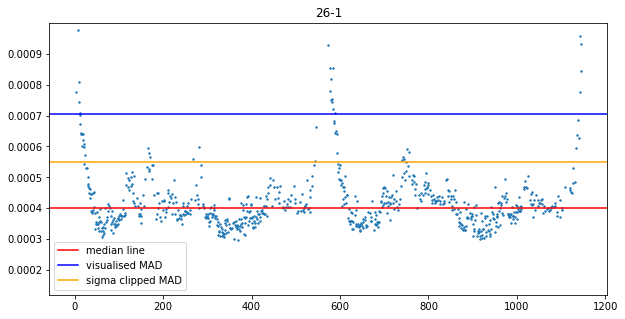

<Figure size 1008x360 with 0 Axes>

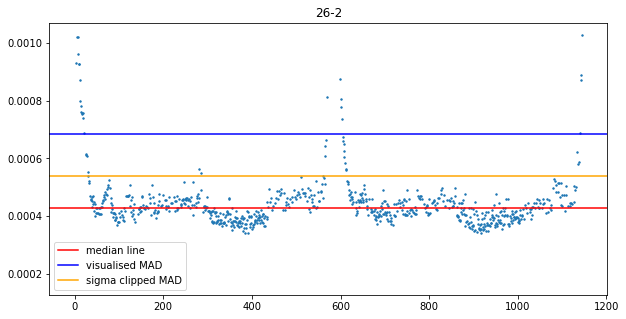

<Figure size 1008x360 with 0 Axes>

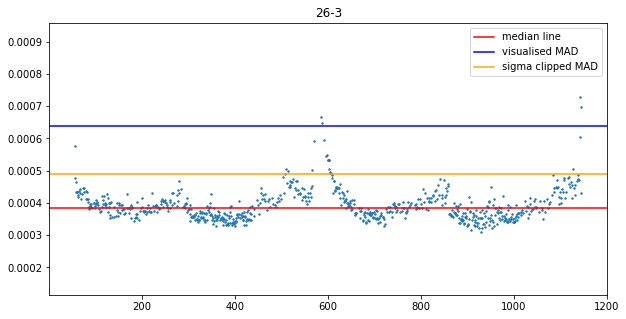

<Figure size 1008x360 with 0 Axes>

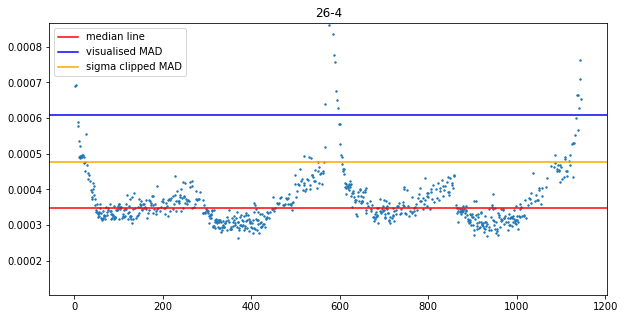

<Figure size 1008x360 with 0 Axes>

In [21]:
sectors = np.arange(1,27,1)
cam = [1,2,3,4]
med_arrs = []
med_sig_clips = []

for i in sectors:
    for j in cam:
        mad_arr = mad_df.loc[:len(lc)-1, f"{i}-{j}"]
        sig_clip = sigma_clip(mad_arr,sigma=3,masked=False)  
        med_sig_clip = np.nanmedian(sig_clip)
        med_arrs.append(np.nanmedian(mad_arr))
        med_sig_clips.append(med_sig_clip)
        rms_sig_clip = np.sqrt(np.std(sig_clip))
        fig,ax = plt.subplots(figsize=(10,5))
        plt.figure(figsize=(14,5))
        ax.scatter(range(0,len(lc.time)), mad_arr, s=2)
        ax.axhline(np.nanmedian(mad_arr), c='r',label='median line')
        ax.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]),c='blue',label='visualised MAD') # 10 sigma threshold
        ax.axhline(med_sig_clip + 3*(np.std(sig_clip)), c='orange',label='sigma clipped MAD')
        ax.set_title(f"{i}-{j}")
        ax.legend()
        ax.set_ylim([0.3*np.nanmedian(mad_arr),2.5*np.nanmedian(mad_arr)])
        #fig.savefig(f"MAD figs/{i}-{j} at {clip} sigma")
        plt.show()


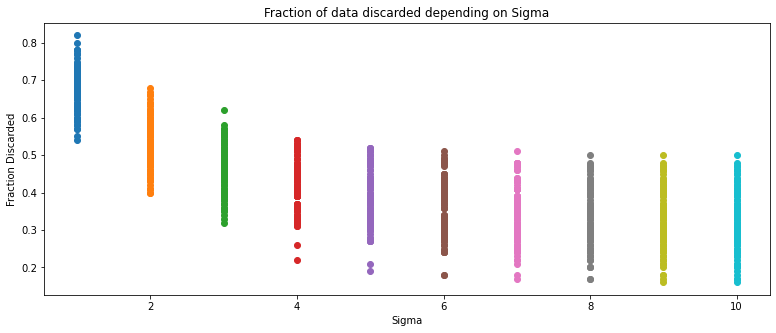

In [22]:
plt.figure(figsize=(13,5))
clip = np.arange(0,10,1)
for i in sectors:
    for j in cam:
        for k in clip:
            mad_arr = mad_df.loc[:len(lc)-1, f"{i}-{j}"]
            sig_clip = sigma_clip(mad_arr,sigma=clip[k]+1,masked=False) # clip[k] + 1 gives sigma clips from 1-10 instead of 0-9
            med_sig_clip = np.nanmedian(sig_clip)
            med_arrs.append(np.nanmedian(mad_arr))
            med_sig_clips.append(med_sig_clip)
            rms_sig_clip = np.sqrt(np.std(sig_clip))            
            mad_cut = mad_arr.values<(med_sig_clip + (np.std(sig_clip)))# gives boolean for values above/below threshold. True if below, False if above
            percent_discard = round((mad_cut == False).sum()/len(mad_arr),2) # mad_arr and mad_cut have same length. mad_cut == False is how many are above the threshold so removed from data
            plt.scatter(clip[k]+1, percent_discard,label=f'{i}-{j} at {clip[k]+1} sigma clip')
            plt.title('Fraction of data discarded depending on Sigma')
            plt.xlabel('Sigma')
            plt.ylabel('Fraction Discarded')
            #plt.legend(bbox_to_anchor=(0.5, -0.05))

#### Numerical SC that has been cut

In [ ]:
percent_discard_list = []
for i in sectors:
    for j in cam:
        for k in clip:
            mad_arr = mad_df.loc[:len(lc)-1, f"{i}-{j}"]
            sig_clip = sigma_clip(mad_arr,sigma=clip[k]+1,masked=False)  
            med_sig_clip = np.nanmedian(sig_clip)
            med_arrs.append(np.nanmedian(mad_arr))
            med_sig_clips.append(med_sig_clip)
            rms_sig_clip = np.sqrt(np.std(sig_clip))            
            mad_cut = mad_arr.values<(med_sig_clip + (np.std(sig_clip)))# removes any values above threshold
            percent_discard = round((mad_cut == False).sum()/len(mad_arr) * 100,4)
            percent_discard_list.append(percent_discard)
            print(f"{percent_discard} percent has been cut from {i}-{j} combination at {clip[k]+1} sigma clip.")
        #print(max(percent_discard_list))

65.9952 percent has been cut from 1-1 combination at 1 sigma clip.
53.3441 percent has been cut from 1-1 combination at 2 sigma clip.
45.7695 percent has been cut from 1-1 combination at 3 sigma clip.
44.2385 percent has been cut from 1-1 combination at 4 sigma clip.
42.224 percent has been cut from 1-1 combination at 5 sigma clip.
39.0008 percent has been cut from 1-1 combination at 6 sigma clip.
32.7961 percent has been cut from 1-1 combination at 7 sigma clip.
31.4263 percent has been cut from 1-1 combination at 8 sigma clip.
31.4263 percent has been cut from 1-1 combination at 9 sigma clip.
31.4263 percent has been cut from 1-1 combination at 10 sigma clip.
64.5447 percent has been cut from 1-2 combination at 1 sigma clip.
50.6849 percent has been cut from 1-2 combination at 2 sigma clip.
45.2055 percent has been cut from 1-2 combination at 3 sigma clip.
43.6745 percent has been cut from 1-2 combination at 4 sigma clip.
41.0959 percent has been cut from 1-2 combination at 5 sigma c

#### A description to which MAD threshold is lower for each SC combination

In [ ]:
# for i in range(1,27):
#     for j in cam:
#         if med_sig_clips[i] < med_arrs[j]:
#             print(f"Sector {i}, Camera {j}, Sigma Clipped MAD has a lower threshold than visualised MAD.")
#         elif round(med_sig_clips[i],9) == round(med_arrs[j],9):
#             print(f"Sector {i}, Camera {j}, roughly the same.")
#         else:
#             print(f"Sector {i}, Camera {j}, visualised MAD has lower threshold.")